# Lesson-03-Best-First-Search-and-A-Start-Search

## 1. Driving Map Navigator

In [1]:
coordination_source = """
{name:'兰州', geoCoord:[103.73, 36.03]},
{name:'嘉峪关', geoCoord:[98.17, 39.47]},
{name:'西宁', geoCoord:[101.74, 36.56]},
{name:'成都', geoCoord:[104.06, 30.67]},
{name:'石家庄', geoCoord:[114.48, 38.03]},
{name:'拉萨', geoCoord:[102.73, 25.04]},
{name:'贵阳', geoCoord:[106.71, 26.57]},
{name:'武汉', geoCoord:[114.31, 30.52]},
{name:'郑州', geoCoord:[113.65, 34.76]},
{name:'济南', geoCoord:[117, 36.65]},
{name:'南京', geoCoord:[118.78, 32.04]},
{name:'合肥', geoCoord:[117.27, 31.86]},
{name:'杭州', geoCoord:[120.19, 30.26]},
{name:'南昌', geoCoord:[115.89, 28.68]},
{name:'福州', geoCoord:[119.3, 26.08]},
{name:'广州', geoCoord:[113.23, 23.16]},
{name:'长沙', geoCoord:[113, 28.21]},
//{name:'海口', geoCoord:[110.35, 20.02]},
{name:'沈阳', geoCoord:[123.38, 41.8]},
{name:'长春', geoCoord:[125.35, 43.88]},
{name:'哈尔滨', geoCoord:[126.63, 45.75]},
{name:'太原', geoCoord:[112.53, 37.87]},
{name:'西安', geoCoord:[108.95, 34.27]},
//{name:'台湾', geoCoord:[121.30, 25.03]},
{name:'北京', geoCoord:[116.46, 39.92]},
{name:'上海', geoCoord:[121.48, 31.22]},
{name:'重庆', geoCoord:[106.54, 29.59]},
{name:'天津', geoCoord:[117.2, 39.13]},
{name:'呼和浩特', geoCoord:[111.65, 40.82]},
{name:'南宁', geoCoord:[108.33, 22.84]},
//{name:'西藏', geoCoord:[91.11, 29.97]},
{name:'银川', geoCoord:[106.27, 38.47]},
{name:'乌鲁木齐', geoCoord:[87.68, 43.77]},
{name:'香港', geoCoord:[114.17, 22.28]},
{name:'澳门', geoCoord:[113.54, 22.19]}
"""

import math
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

- Parse the Coordination Text Source to dictionary data
- 将经纬度坐标转换为千米
- draw networks
- generating edges and graph

In [2]:
import re
import networkx as nx
def get_coordination_dict(coordination_source):
    city = re.findall('name:\'(\w+)\'', coordination_source)
    coordination = [(float(long), float(lat)) for long, lat in re.findall('geoCoord:\[(.+),(.+)]', coordination_source)]
    return dict(zip(city,coordination))

city_coordinates = get_coordination_dict(coordination_source)
city_names = list(city_coordinates.keys())

city_graph = nx.Graph()
city_graph.add_nodes_from(city_names)

nx.draw(city_graph, city_coordinates, with_labels=True, node_size=20)

In [3]:
def get_geo_distance(origin, destination):
    global city_coordinates
    return geo_distance(city_coordinates[origin], city_coordinates[destination])

get_geo_distance('杭州', '上海')

153.5185697155768

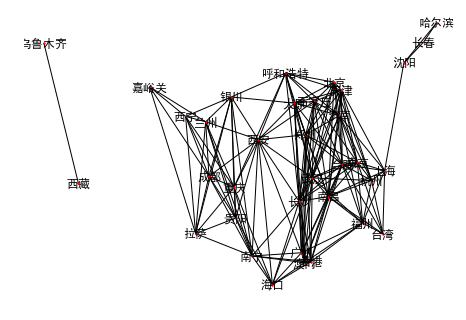

In [4]:
threshold = 700
city_edges = {s:[e for e in city_names if get_geo_distance(s,e) <= threshold] for s in city_names}
city_edges_graph = nx.Graph(city_edges)

nx.draw(city_edges_graph, city_coordinates, with_labels=True, node_size=2)

## 2. Searching Paradigm
- Paradigm
- Best first search
- A star

In [5]:
import debug_tools

def search_destination(graph, start, get_successor_func, is_goal_func, stratey_func):
    pathes = [[start]]
    seen = set()
    chosen_pathes = []
    while pathes:
        path = pathes.pop(0)
        frontier = path[-1]
        if frontier in seen: continue
        for successor in get_successor_func(frontier, graph):
            if successor in path: continue
            new_path = path + [successor]
            pathes.append(new_path)
            if is_goal_func(successor):
                return new_path
            
        pathes = stratey_func(pathes)
        seen.add(frontier)
    return chosen_pathes

# @debug_tools.debug_print
def get_successors(frontier, graph:dict):
    return graph[frontier]

def is_goal(node, destination): 
    return node == desitnation

def sort_pathes(pathes, func, beam): #and beam search
    return sorted(pathes, key=func)[:beam]

# @debug_tools.debug_print
def get_path_distance(path):
    return sum([get_geo_distance(path[i], path[i+1]) for i in range(len(path)-1)])

感觉这里面的chosen_pathes貌似没有用到。我的理解是分三种情况，这里使用第一种理解：

1. 只要找到第一条符合条件的路径：这里面chosen_pathes被设计成空list代表没找到，不需要改动

2. 要在约束不重复访问的情况下找到尽可能多的符合条件的pathes：这里中间的return new_path 改成 chosen_pathes.append(new_path)

3. 想要找到所有可能的path：去掉关于seen的判断+情况2的改动

stanleyliu15:
```
@minquan2 @bluan @anan113 大家好。前面路线少没意识到这个重要性。
在北京地铁换乘的构造中还是存在这个问题：
1，如果保留这一句if frontier in seen:continue，那么找出来的全线路很少，即使后面放了strategy，其实谈不上起多少作用
2，如果放弃这一句，那么找出来的全线路太多了，虽然不至于死循环，但是太多了，很多没有必要的绕远路再返回的这种低效线路也在其中。虽然这些低效线路也许能被strategy筛掉，但历遍这些低效线路实在不是个办法
3，anan的图片是在这个卡片吗？我没看到改变位置，只看到去掉了这句的全线路，所以有和2所说一样的问题。
4，保留if city in path: continue，这句没问题，避免单条路线成环。这句肯定是要有的。
```
bluan:
```
@stanleyliu15 你好，我认为你说的很对。我之前也自己捉摸了一下关于seen这个东西存在的意义。我觉得其实把这个东西抽象一下的话，if frontier in seen:continue 这句话的本质是去通过一定的方法对复杂度进行约束，复杂度可以认为是O(|N|+|E|)，这里N是node的数量，E是edge的数量。

通过seen来看是一种方法，但是我觉得这种方法在一定程度上会一刀切的局限性，有可能会漏掉比较好的解。我个人认为，用strategy sort一下之后加上beam search的思路也可以同样达到约束复杂度的作用，而且自由度会高一些，逻辑上也更能说的通，但是beam search的复杂度有可能略高于seen的方法。

但是最终用什么办法还是得看应用场景，如果node数量特别多，那么seen的确是一个不错的办法
```
minquan2:
```
@stanleyliu15 @bluan @anan113 hi，你说的那个会产生很多绕远路然后再回去的这个情况就是之前提过的“剪枝”问题。 我们需要在扩展的时候把那些不可能的点，依照某种衡量标准去掉。 这个在我们数据量比较大的时候是一定需要的。
```


In [6]:
# @debug_tools.debug_print
def comprehensive_sort(pathes):
    return sort_pathes(pathes, lambda p: (len(p) + get_path_distance(p)), beam=30)

def mini_change_station(pathes):
    return sort_pathes(pathes, lambda p: len(p), beam=-1)

def min_distance(pathes):
    return sort_pathes(pathes, lambda p:get_path_distance(p), beam=-1)

In [7]:
search_destination(city_edges, '北京', get_successors, lambda end: end == '拉萨', comprehensive_sort)

['北京', '武汉', '长沙', '南宁', '拉萨']

In [8]:
search_destination(city_edges, '北京', get_successors, lambda end: end == '拉萨', mini_change_station)

['北京', '长沙', '南宁', '拉萨']

In [9]:
search_destination(city_edges, '北京', get_successors, lambda end: end == '拉萨', min_distance)

['北京', '呼和浩特', '银川', '拉萨']